In [1]:
import pymysql
from sqlalchemy import create_engine 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import time

In [ ]:
def get_ts_map_start_end(match_id=None): # get map start and end times from pickle
    '''
    parameters: match_id: int

    returns:    ts_match_start, ts_map_start, ts_map_end (int, pandas.Series, pandas.Series)
    '''
    # get map start and end time
    path = 'D:\owl-data\pickles'
    file_name = 'OWL_map_start_info'
    timestamps = pd.read_pickle(os.path.join(path, file_name))

    # send error msg if there is no match_id
    if timestamps['esports_match_id'].isin([match_id]).any() == False:
        raise ValueError('there is no match_id in OWL_map_start_info')

    timestamps = timestamps[timestamps['esports_match_id'] == match_id]
    timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
    ts_match_start = timestamps['time_gamestart'].min()

    ts_map_start = timestamps['time_gamestart']
    ts_map_start.reset_index(drop=True, inplace=True)
    ts_map_end = timestamps['time_gameresult']
    ts_map_end.reset_index(drop=True, inplace=True)
    
    return ts_match_start, ts_map_start, ts_map_end

In [ ]:
def get_team_info(match_id=None):
    '''
    parameters: match_id: int

    returns:    team_one_name, team_one_id, team_two_name, team_two_id (str, int, str, int)
    '''
    # get team_names
    path = 'D:\owl-data'
    file_name = 'OWL_match_results.csv'
    match_results = pd.read_csv(os.path.join(path, file_name))
    match_results = match_results[match_results['esports_match_id'] == match_id][['team_one_name', 'team_two_name']]
    match_results.reset_index(inplace=True)
    team_one_name = match_results.loc[0, 'team_one_name']
    team_two_name = match_results.loc[0, 'team_two_name']
    
    # get team_ids
    esports_team_id = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'df_esports_team_id.pickle'))
    team_one_id = int(esports_team_id[esports_team_id['team_name'] == team_one_name]['team_id'])
    team_two_id = int(esports_team_id[esports_team_id['team_name'] == team_two_name]['team_id'])

    return team_one_name, team_one_id, team_two_name, team_two_id

In [ ]:
def get_map_info(match_id=None):
    '''
    parameters: match_id: int

    returns:    map names (series)
    '''
    # get team_names
    path = 'D:\owl-data'
    file_name = 'OWL_match_results.csv'
    match_results = pd.read_csv(os.path.join(path, file_name))
    match_results = match_results[match_results['esports_match_id'] == match_id][['map_name']]
    match_results.reset_index(inplace=True)
    map_names = match_results['map_name']
    
    return map_names

In [ ]:
# Get event timestamps
def getEvents(match_id=None, ssg=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # send query
    table_id = f'match_{match_id}'

    if team_id == 0: # default
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' ORDER BY `time`;"
    else: # where designated team_id
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' AND `esports_team_id` = '{team_id}' ORDER BY `time`;"

    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time in ms
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)

    # get map start times and end times
    map_start_times = ts_map_start - ts_match_start # set match start time as 0
    map_end_times = ts_map_end - ts_match_start # set match start time as 0

    # groupby df
    df2 = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    df2['time'] = pd.to_numeric(df2['time'])
    df2['time'] = df2['time'] / 1000 # ms to s
    df2['time'] = df2['time'] - ts_match_start # set match start time as 0

    sum_df = df2.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps
    
    sum_df = sum_df.droplevel(level='short_stat_guid')
    sum_df = sum_df.reset_index(level='time')
    sum_df['dx'] = sum_df['amount'].diff()
    sum_df['dt'] = sum_df['time'].diff()
    sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
    
    # define event time with threshold
    sum_df['event'] = sum_df['dx'] > threshold # True if dx > threshold
    
    # transform time (int) into UTC datetime
    sum_df['time'] += ts_match_start
    sum_df['time'] = pd.to_datetime(sum_df['time'], unit='s', utc=True)
    
    # resample
    # sum_df = sum_df.resample(interval, on='time').sum()

    return sum_df

In [ ]:
def getEvents_alives(match_id=None, team_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    events_lives = getEvents(match_id=match_id, ssg=1136, team_id=team_id)
    events_deaths = getEvents(match_id=match_id, ssg=41, team_id=team_id)
    events_alives = events_lives.merge(events_deaths, how='outer', on='time')
    events_alives['amount_y'].fillna(0, inplace=True)
    events_alives['amount'] = events_alives['amount_x'] - events_alives['amount_y']
    events_alives = events_alives[['time', 'amount']]
    
    return events_alives

In [ ]:
def getEvents_teampowerbalance(match_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}

    returns:    events_teampowerbalance (pandas.DataFrame[['time', 'amount_{team_one}', 'amount_{team_two}', 'TPB']])
    '''
    # get team info
    team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=match_id)

    team_one_alives = getEvents_alives(match_id=match_id, team_id=team_one_id)
    team_two_alives = getEvents_alives(match_id=match_id, team_id=team_two_id)
    events_teampowerbalance = team_one_alives.merge(team_two_alives, how='outer', on='time', suffixes=(f'_{team_one_name}', f'_{team_two_name}'))
    events_teampowerbalance['TPB'] = (events_teampowerbalance[f'amount_{team_one_name}'] * events_teampowerbalance[f'amount_{team_one_name}']) - (events_teampowerbalance[f'amount_{team_two_name}'] * events_teampowerbalance[f'amount_{team_two_name}'])

    return events_teampowerbalance

In [ ]:
def getEvents_finalblows(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 44

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [ ]:
def getEvents_herodamagedone(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=400):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 400 (float)

    returns:    event_alldamagedone (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 1208 # Hero_Damage_Done

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [5]:
def to_datetime(time):
    '''
    parameters: time: UTC timestamp in second(int)

    returns:    pd. datetime in seconds, UTC
    '''
    t = pd.to_datetime(time, unit='s', utc=True)

    return t

In [ ]:
# TF detector
def TF_detector(df_rolling):
    '''
    parameters: dataframe
    <시작 조건>
    시작 조건 0. TF 중 = False
    시작 조건 1. time > 이전 TF 종료 시간
    시작 조건 2. HDD >= {HDD_threshold=500} (time - )
    시작 조건 3. FB > 0, time - {possible_time_variance=1}
    시작 조건 4. HDD >= {HDD_threshold=500} 시간 이후, first FB=False 상태로 HDD < {HDD_lull_cut=50} 생기면 이전 HDD time 제외

    <종료 조건>
    종료 조건 0. TF 진행 중 = True
    종료 조건 1. FB = 0 이 {no_FB_duration=10}초 이상
    종료 조건 2. time = ts_map_end_time

    *stagger
    *길어지는 한타
    FB 0 되고 10s동안 추가 킬이 없어야 한타 종료로 인정

    return:     TF_timestamps: dataframe of [['match_id', 'map_num', 'TF_start_time_stamps', 'TF_end_time_stamps']]
    '''
    global is_TF_ongoing
    is_TF_ongoing = False
    global FB_happened
    FB_happened = False
    global FB_silence
    FB_silence = False

    TF_start_time_stamps = []
    TF_end_time_stamps = []

    HDD_threshold = 500
    HDD_lull_cut = 500
    FB_threshold = 0
    possible_time_variance = 2
    no_FB_duration = 10

    # start condition
    def TF_start(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence
        
        def condition0(): # TF 중 = False
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = False
            else:
                cond0 = True
            return cond0

        def condition1(idx): # time > 이전 TF 종료 시간
            if (idx < df_rolling.index[-1]) == True:
                cond1 = True
            else:
                cond1 = False
            return cond1

        def condition2(idx): # HDD >= {HDD_threshold}
            if df_rolling.loc[idx, 'HDD'] > HDD_threshold:
                cond2 = True
            else:
                cond2 = False
            return cond2 
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # HDD가 오르는 추세에 있어야
            if (df_rolling.loc[idx - pd.to_timedelta(no_FB_duration, unit='s') : idx, 'HDD'].mean() <= df_rolling.loc[idx : idx + pd.to_timedelta(no_FB_duration, unit='s'), 'HDD'].mean()) == True:
                cond4 = True
            else:
                cond4 = False
            return cond4 
        
        def condition5(idx): # HDD 가 {no_FB_duration} 범위에서 최소값일 경우
            if (df_rolling.loc[idx, 'HDD'] <= df_rolling.loc[idx : idx + pd.to_timedelta(no_FB_duration, unit='s'), 'HDD'].min()) == True:
                cond5 = True
            else:
                cond5 = False
            return cond5 


        # check if start_condition == True
        start_condition = condition0() & condition1(idx) & ( (condition2(idx) & condition4(idx) & condition5(idx)) | condition3(idx) ) 
        
        if start_condition == True:
            is_TF_ongoing = True # toggle on
            FB_silence = False # toggle off

        return is_TF_ongoing
    
    # end condition
    def TF_end(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence

        def condition0(): # TF 진행 중 = True
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = True
            else:
                cond0 = False 
            return cond0

        def condition1(idx): # FB = 0 이 {no_FB_duration}초 이상 유지될 때
            global FB_silence
            if df_rolling.loc[idx: idx + pd.to_timedelta(no_FB_duration, unit='s'), 'FB'].sum() == 0:
                cond1 = True 
                FB_silence = True # toggle on
            else:
                cond1 = False
            return cond1 
        
        def condition2(idx): # time = ts_map_end_time (Map이 종료됐을 때)
            if idx == df_rolling.index[-1]:
                cond2 = True
            else:
                cond2 = False
            return cond2
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # while FB == 0 & HDD <= {HDD_lull_cut}
            if (df_rolling.loc[idx, 'FB'] == 0) & (df_rolling.loc[idx, 'HDD'] <= HDD_lull_cut):
                cond4 = True
            else:
                cond4 = False
            return cond4
        
        def condition5(idx): # 2s 동안 mean(HDD) < HDD_threshold 
            if df_rolling.loc[idx:idx + pd.to_timedelta(2, unit='s'), 'HDD'].mean() < HDD_threshold:
                cond5 = True
            else:
                cond5 = False
            return cond5

        # init FB_happened
        condition3(idx)

        # check if end_condition == True
        end_condition = ( condition0() & ((condition1(idx) & condition5(idx)) & FB_happened) | (FB_happened & condition4(idx)) ) | condition2(idx)

        if end_condition == True:
            is_TF_ongoing = False # toggle off
            FB_happened = False # toggle off

        return is_TF_ongoing

    TF_status = []

    for idx in df_rolling.index:
        if is_TF_ongoing == False:
            TF_status.append(TF_start(idx))
        else:
            TF_status.append(TF_end(idx))

    df_rolling['TF_status'] = TF_status

    return df_rolling # [['TPB', 'HDD', 'FB', 'TF_status']], index=UTC timestamp

In [ ]:
# get TF_time_range
def get_true_range(df=None, column='TF_status'):
    '''
    parameters: data: dataframe with timestamp index
                column: target column to arrange
    
    returns:    index tuple
    '''
    range_list = []
    prev_val = False

    for inx, val in df[column].iteritems():
        if prev_val != val:
            if val:
                start = inx
            else:
                range_list.append((start, inx))

        prev_inx = inx
        prev_val = val
    
    return range_list

In [ ]:
def get_esports_match_ids(team_name='All', opponent_name='All', winner='All', loser='All', season='All', map_name='All'):
    '''
    parameters: team_name: target team name
                opponent_name: opponent team name
                winner: winner team name
                loser: loser team name
                season: 2018, 2019, 2020
                map: map name
                period: datetime range e.g.('2020-08-01':'2020-09-01')
    
    returns:    esports_match_ids
    '''
    df = pd.read_csv(os.path.join('D:\owl-data', 'OWL_match_results.csv'))

    # df1 (search team_name)
    if team_name == 'All':
        df1 = df
    else:
        df1 = pd.concat([df[df['team_one_name'].str.contains(team_name)], df[df['team_two_name'].str.contains(team_name)]])
    
    # df2 (search opponent_name)
    if opponent_name == 'All':
        df2 = df1
    else:
        df2 = pd.concat([df1[df1['team_one_name'].str.contains(opponent_name)], df1[df1['team_two_name'].str.contains(opponent_name)]]) 
    
    # df3 (search winner)
    if winner == 'All':
        df3 = df2
    else:
        df3 = df2[df2['match_winner'] == winner]
    
    # df4 (search loser): loser 검색 시에는 반드시 team_name or opponent_name 설정을 해줘야 함
    if loser == 'All':
        df4 = df3
    else:
        if team_name == 'All' & opponent_name == 'All':
            raise ValueError('define team_name or opponent_name first')
        else:
            df4 = df3[df3['match_winner'] != loser]
    
    # df5 (search season)
    if season == 'All':
        df5 = df4
    else:
        season_id = str(season - 2017) # 2018 = 1st season
        df5 = df4[df4['esports_match_id'].astype(str).str.startswith(season_id)]

    # df6 (search map_name)
    if map_name == 'All':
        df6 = df5
    else:
        df6 = df5[df5['map_name'].str.contains(map_name)]

    esports_match_ids = df6['esports_match_id'].unique()

    return esports_match_ids

## Get Teamfight timestamps and info

In [ ]:
def get_teamfight_info(match_id=None, plotting=False, **kwargs):
    '''
    parameters:     match_id
                    plotting: plot graphs if True
                    *kwargs: item=['HDD', 'FB', 'TPB'] (maximum 2 of 3 items to plot. ex. ['HDD', 'FB'])

    returns:        dataframe of teamfight info
    '''
    # HDB, FB, TPB
    stat_lifespan = 'GAME'
    events_finalblows = getEvents_finalblows(match_id=match_id, stat_lifespan=stat_lifespan)
    events_herodamagedone = getEvents_herodamagedone(match_id=match_id, stat_lifespan=stat_lifespan)
    events_TPB = getEvents_teampowerbalance(match_id=match_id, stat_lifespan=stat_lifespan)

    # put all relevant stats into df_TF
    # TPB
    df1 = events_TPB[['time', 'TPB']]
    # HDD
    df2 = events_herodamagedone[['time', 'dx']]
    df2 = df2.rename(columns={'dx':'HDD'})
    # FB
    df3 = events_finalblows[['time', 'dx']]
    df3 = df3.rename(columns={'dx':'FB'})
    # merge
    df_TF = df1.merge(df2, how='outer', on='time')
    df_TF = df_TF.merge(df3, how='outer', on='time')
    # remove (-) values in HDD/s and FB (it appears when a map starts cuz 'dx' was calculated by diff())
    df_TF = df_TF[df_TF['HDD'] >= 0]
    df_TF = df_TF[df_TF['FB'] >= 0]

    # resampling to align timeline
    resample = df_TF.resample('2s', on='time').sum()

    # get df of rolling with moving window
    window = 5 # indicates 10 sec (window * 2 sec (Blizzard provides 2sec ESD sampling frequency))
    rolling = resample.rolling(window=window, center=True, min_periods=1).sum() # sum rolling windows with min_periods=1

    # get map info
    map_names = get_map_info(match_id=match_id)

    # get team info
    team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=match_id)
    
    # match start timestamps
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)
    ts_match_start = pd.to_datetime(ts_match_start, unit='s', utc=True)

    # get df of teamfight info
    df_TF_match = pd.DataFrame()

    for m in map_names.index:
        df_map = rolling[to_datetime(ts_map_start[m]): to_datetime(ts_map_end[m])]
        df_map = TF_detector(df_map)
        TF_time_range = get_true_range(df_map)


        # get teamfight info by maps
        df_TF_map = pd.DataFrame(TF_time_range, columns=['TF_start_datetime', 'TF_end_datetime'])
        df_TF_map['esports_match_id'] = match_id
        df_TF_map['map_name'] = map_names[m]
        df_TF_map['map_order'] = m + 1
        
        # define TF winner and TPB
        TF_winner_list = []
        TF_order_list = []
        TF_duration_list = []
        TF_TPB_list = []
        TF_TPBps_list = [] # TPB/s
        TF_order = 0
        
        for idx in df_TF_map.index:
            TF_order += 1
            TF_order_list.append(TF_order)
            TF_duration_list.append((df_TF_map.loc[idx, 'TF_end_datetime'] - df_TF_map.loc[idx, 'TF_start_datetime']).seconds) # TF duration in s
            TF_TPB_sum = df_map.loc[df_TF_map.loc[idx, 'TF_start_datetime']:df_TF_map.loc[idx, 'TF_end_datetime'], 'TPB'].sum()
            TF_TPB_list.append(TF_TPB_sum) # TPB
            TF_TPBps_list.append(TF_TPB_sum / ((df_TF_map.loc[idx, 'TF_end_datetime'] - df_TF_map.loc[idx, 'TF_start_datetime']).seconds)) # TPB / s
            if TF_TPB_sum > 0:
                TF_winner_list.append(team_one_name)
            elif TF_TPB_sum == 0:
                TF_winner_list.append('draw')
            else:
                TF_winner_list.append(team_two_name)
        df_TF_map['TF_order'] = TF_order_list
        df_TF_map['TF_winner'] = TF_winner_list
        df_TF_map['TF_duration'] = TF_duration_list
        df_TF_map['TF_TPB_sum'] = TF_TPB_list
        df_TF_map['TF_TPB_sum/s'] = TF_TPBps_list

        # plot if plotting == True
        fig_opt={'figsize':(20,10), 'linewidth':1, 'color_TF_shading':'gray', 'color_HDD':'green', 'color_FB':'red', 'color_TPB':'black'}
        if plotting == True:
            figsize = fig_opt['figsize']
            linewidth = fig_opt['linewidth']
            color_TF_shading = fig_opt['color_TF_shading']
            color_HDD = fig_opt['color_HDD']
            color_FB = fig_opt['color_FB']
            color_TPB = fig_opt['color_TPB']

            plt.figure(figsize=figsize)

            plt.title(f'{match_id}_{team_one_name} vs {team_two_name} in {map_names[m]}')

            pitem = kwargs['item'] # get plotting items
            if len(pitem) == 1: # only one item
                # set line color
                if 'HDD' in pitem == True:
                    color = color_HDD
                elif 'FB' in pitem == True:
                    color = color_FB 
                elif 'TPB' in pitem == True:
                    color = color_TPB 
                
                sns.lineplot(x='time', y=pitem, data=df_map, color=color, linewidth=linewidth)  
                plt.ylabel(pitem)
            
            elif len(pitem) > 1:
                # set line color
                if pitem[0] == 'HDD':
                    color0 = color_HDD
                elif pitem[0] == 'FB':
                    color0 = color_FB 
                elif pitem[0] == 'TPB':
                    color0 = color_TPB 

                if pitem[1] == 'HDD':
                    color1 = color_HDD
                elif pitem[1] == 'FB':
                    color1 = color_FB 
                elif pitem[1] == 'TPB':
                    color1 = color_TPB 

                ax = sns.lineplot(x='time', y=pitem[0], data=df_map, color=color0, linewidth=linewidth)
                plt.ylabel(pitem[0])
                ax1 = ax.twinx()
                sns.lineplot(x='time', y=pitem[1], data=df_map, color=color1, ax=ax1, linewidth=linewidth)
                plt.ylabel(pitem[1])
            
            elif len(pitem) > 2:
                raise ('Too many items to plot')

            
            # plot shading during teamfight
            for (start, end) in TF_time_range:
                plt.axvspan(start, end, color=color_TF_shading, alpha=0.5)

            plt.xlim(to_datetime(ts_map_start[m]), to_datetime(ts_map_end[m]))
            plt.show()

        # concat into df_TF_match
        df_TF_match = pd.concat([df_TF_match, df_TF_map], ignore_index=True)
        
    
    return df_TF_match

In [ ]:
# plotting teamfight
df_ = get_teamfight_info(match_id=match_id, plotting=True, item=['HDD', 'TPB'])

## Save and Export to csv

In [ ]:
# save df as csv in results folder

match_ids = pd.read_csv('OWL_match_results.csv')['esports_match_id'].unique()

for match_id in match_ids:
    try:
        df_ = get_teamfight_info(match_id=match_id, plotting=False)
        df_.to_csv('results/tf_info'+f'{match_id}.csv')
    except:
        print(f'not in mysql: {match_id}')

## Cleansing

In [2]:
class Match:
    def __init__(self, match_id=None):
        self.match_id = match_id
        self.set_match_result_summary()
        self.set_match_variables()

    def set_match_result_summary(self):
        '''
        requirements:   'OWL_match_results.csv'
        '''
        path = 'D:\owl-data'
        file_name = 'OWL_match_results.csv'
        match_result_summary = pd.read_csv(os.path.join(path, file_name))
        match_result_summary = match_result_summary[match_result_summary['esports_match_id'] == self.match_id]
        match_result_summary.reset_index(inplace=True)
        match_result_summary = match_result_summary[['start_time', 'esports_match_id', 'map_name', 'team_one_name', 'team_two_name', 'match_winner', 'map_winner', 'winning_team_final_map_score', 'losing_team_final_map_score']]

        self.match_result_summary = match_result_summary
    
    def get_match_result_summary(self):
        return self.match_result_summary

    def set_match_variables(self):
        '''
        requirements:   'df_esports_team_id.pickle', 'OWL_map_start_info'
        '''
        # team_names
        self.team_names = [self.match_result_summary['team_one_name'][0], self.match_result_summary['team_two_name'][0]]
        # match_winner_name
        self.match_winner_name = self.match_result_summary['match_winner'][0]
        # match_loser_name
        for team in self.team_names:
            if team == self.match_winner_name:
                pass 
            else: 
                self.match_loser_name = team
        # team_ids
        esports_team_id = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'df_esports_team_id.pickle'))
        self.team_ids = [int(esports_team_id[esports_team_id['team_name'] == self.team_names[0]]['team_id']), int(esports_team_id[esports_team_id['team_name'] == self.team_names[1]]['team_id'])]
        self.match_winner_id = int(esports_team_id[esports_team_id['team_name'] == self.match_winner_name]['team_id'])
        self.match_loser_id = int(esports_team_id[esports_team_id['team_name'] == self.match_loser_name]['team_id'])
        # box score
        self.box_score_winner = sum(self.match_result_summary['map_winner'] == self.match_winner_name)
        self.box_score_loser = sum(self.match_result_summary['map_winner'] == self.match_loser_name)
        # time info
        def get_ts_map_start_end(match_id=None): # get map start and end times from pickle
            '''
            parameters: match_id: int

            returns:    ts_match_start, self.ts_map_start, ts_map_end (int, pandas.Series, pandas.Series)
            '''
            # get map start and end time
            path = 'D:\owl-data\pickles'
            file_name = 'OWL_map_start_info'
            timestamps = pd.read_pickle(os.path.join(path, file_name))

            # send error msg if there is no match_id
            if timestamps['esports_match_id'].isin([match_id]).any() == False:
                raise ValueError('there is no match_id in OWL_map_start_info')

            timestamps = timestamps[timestamps['esports_match_id'] == match_id]
            timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
            ts_match_start = timestamps['time_gamestart'].min()

            ts_map_start = timestamps['time_gamestart']
            ts_map_start.reset_index(drop=True, inplace=True)
            ts_map_end = timestamps['time_gameresult']
            ts_map_end.reset_index(drop=True, inplace=True)
            
            return ts_match_start, ts_map_start, ts_map_end
        self.ts_match_start, self.ts_map_start, self.ts_map_end = get_ts_map_start_end(match_id=self.match_id)


    def import_esd(self, dbname="esd_phs", stat_lifespan='GAME', stat_category='Hero', **kwargs):
        '''
        parameters: match_id
                    kwargs: ['index', 'time', 'hero_guid', 'stat_lifespan', 'hero_name', 'short_stat_guid', 'amount', 'stat_name', 'stat_category', 'battletag', 'esports_player_id', 'esports_team_id']
        
        returns:    pd.DataFrame from MySQL DB
        '''
        # get sql from parameters
        table_id = f'match_{self.match_id}'
        sql = f"SELECT * FROM `{table_id}` WHERE `stat_lifespan` = '{stat_lifespan}' AND `stat_category` = '{stat_category}'"
        
        if len(kwargs) != 0:
            for name, value in kwargs.items():
                sql = sql + f" AND `{name}` = '{value}'"
        sql = sql + " ORDER BY `time`;"
        print(sql)

        # Credentials to DB connection
        hostname = "localhost" 
        username = "root"
        pwd = "gpdlzjadh"
        dbname = dbname #"esd_phs"
        charset = "utf8"

        # Create connection to MySQL DB
        conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
        cur = conn.cursor()

        # send query
        df = pd.read_sql(sql, conn)

        cur.close()
        conn.close()

        # preprocess dataframe
        # convert `time` column type from str to datetime
        df['time'] = df['time'].astype(float)
        df['time'] = df['time'] / 1000 # ms to s
        df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
        
        df['battletag'] = df['battletag'].str.split('#').str[0] # drop str after '#' in `battletag`
        df.drop(['index'], axis=1, inplace=True)
        df.set_index('time', inplace=True) # set 'time' column as index

        # slice only map played timeline
        esd_tf = pd.DataFrame()
        for idx in self.ts_map_start.index:
            start, end = to_datetime(self.ts_map_start.loc[idx]), to_datetime(self.ts_map_end.loc[idx])
            df_tmp = df[start:end]
            df_tmp['map_order'] = idx + 1
            
            esd_tf = pd.concat([esd_tf, df_tmp], ignore_index=False) # index:datetime
        
        return esd_tf

In [3]:
class Teamfight(Match):
    def __init__(self, match_id=None):
        self.match_id = match_id
        self.set_match_result_summary()
        self.set_match_variables()
    
    def get_TF_trends(self, short_stat_guid=None, map_order=1):
        '''
        paramters:  match_id:  
                    short_stat_guid:
                    map_order:
        
        returns:    dataframe
        '''
        # get ESD from MySQL DB
        timeplayed = self.import_esd(short_stat_guid=33) # get timeplayed to set time-axis
        timeplayed = timeplayed[timeplayed['map_order'] == map_order]
        target_stat = self.import_esd(short_stat_guid=short_stat_guid)
        target_stat = target_stat[target_stat['map_order'] == map_order]

        # grouping
        group_timeplayed = timeplayed.groupby(by=['time', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].mean()
        group_target_stat = target_stat.groupby(by=['time', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].mean()

        # get amount, dx, dt, dx/dt
        df_merge = pd.merge(group_timeplayed, group_target_stat, how='outer', left_index=True, right_index=True, suffixes=('_timeplayed', '_target_stat'))
        # df_merge['amount_target_stat'].fillna(0, inplace=True) # initialize stat value

        df_merge['dx'] = df_merge.groupby(level=['esports_team_id', 'battletag', 'hero_name'])['amount_target_stat'].diff().fillna(df_merge['amount_target_stat']) # fill nan as first value
        df_merge['dt'] = df_merge['dx'].reset_index('time').groupby(level=['esports_team_id', 'battletag', 'hero_name'])['time'].diff().dt.seconds.values
        df_merge['dx/dt'] = df_merge['dx'].div(df_merge['dt'], axis=0)

        # reset index of esports_team_id
        df_merge.reset_index('esports_team_id', inplace=True)
        
        return df_merge


In [136]:
# match results
# set match_id, instance
match_id = 34912
match = Match(match_id)
# match winner and loser
match_winner_name = match.match_winner_name
match_loser_name = match.match_loser_name
# box scores
box_score = (match.box_score_winner, match.box_score_loser)
print(f'box score: {match_winner_name} {box_score[0]} vs {box_score[1]} {match_loser_name}')
# match result summary
match_result_summary = match.get_match_result_summary()
# match dashboard
# display(match.import_esd(short_stat_guid=44))
# TF
teamfight = Teamfight(match_id)
teamfight.get_TF_trends(short_stat_guid=43)


box score: New York Excelsior 3 vs 2 Guangzhou Charge
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '43' ORDER BY `time`;


esports_team_id  \
time                                battletag hero_name                        
2020-08-08 11:44:51.322999954+00:00 BiaNcA    Zarya                   4403.0   
                                    Haksal    Symmetra                4403.0   
                                    JJonak    Zenyatta                4403.0   
                                    Mano      Wrecking Ball           4403.0   
                                    Nenne     Ashe                    4403.0   
...                                                                      ...   
2020-08-08 11:54:59.642999887+00:00 Rio       Winston                 7699.0   
                                              Wrecking Ball           7699.0   
                                    shu       Ana                     7699.0   
                                              Baptiste                7699.0   
                                              Moira                   7699.0   

                                                             amount_timeplayed  \
time                                battletag hero_name                          
2020-08-08 11:44:51.322999954+00:00 BiaNcA    Zarya                   1.949440   
                                    Haksal    Symmetra                0.974463   
                                    JJonak    Zenyatta                0.974463   
                                    Mano      Wrecking Ball           0.974463   
                                    Nenne     Ashe                    0.974463   
...                                                                        ...   
2020-08-08 11:54:59.642999887+00:00 Rio       Winston                45.746200   
                                              Wrecking Ball          97.365900   
                                    shu       Ana                    41.854800   
                                              Baptiste              428.248000   
                                              Moira                  95.412900   

                                                             amount_target_stat  \
time                                battletag hero_name                           
2020-08-08 11:44:51.322999954+00:00 BiaNcA    Zarya                         NaN   
                                    Haksal    Symmetra                      NaN   
                                    JJonak    Zenyatta                      NaN   
                                    Mano      Wrecking Ball                 NaN   
                                    Nenne     Ashe                          NaN   
...                                                                         ...   
2020-08-08 11:54:59.642999887+00:00 Rio       Winston                       NaN   
                                              Wrecking Ball                 NaN   
                                    shu       Ana                           NaN   
                                              Baptiste                      2.0   
                                              Moira                         1.0   

                                                              dx   dt  dx/dt  
time                                battletag hero_name                       
2020-08-08 11:44:51.322999954+00:00 BiaNcA    Zarya          NaN  NaN    NaN  
                                    Haksal    Symmetra       NaN  2.0    NaN  
                                    JJonak    Zenyatta       NaN  2.0    NaN  
                                    Mano      Wrecking Ball  NaN  2.0    NaN  
                                    Nenne     Ashe           NaN  2.0    NaN  
...                                                          ...  ...    ...  
2020-08-08 11:54:59.642999887+00:00 Rio       Winston        NaN  NaN    NaN  
                                              Wrecking Ball  NaN  2.0    NaN  
                                    shu       Ana            NaN  2.0    NaN  
    

In [209]:
class StatReport(Match):
    ssg_dict = {'Time Played':33, 'Final Blows':43}
    # ssg_dict = {'Time Played':33, 'Final Blows':43, 'Deaths':42, 'Hero Damage Done':1207, 'Barrier Damage Done':1301, 'Hero Damage Taken':401, 'Healing Done':449, 'Healing Received': 1716, 'Ultimate Earned':1122, 'Ultimate Used':1123, 'Assists':1319, 'Solo Kills':45}
    
    def __init__(self, match_id):
        self.match_id = match_id
        self.set_match_result_summary()
        self.set_match_variables()
        self.set_mode()
        self.set_category()
        self.set_grouping()
        self.set_ssg_dict()
        self.set_trends()

    def set_mode(self, mode='match'):
        '''
        parameters: str, {'match', 'map', 'teamfight'}, default: 'match'
        '''
        self.mode = mode

    def set_category(self, category='team'):
        '''
        parameters: str, {'team', 'player'}, default: 'team'
        '''
        self.category = category
    
    def set_grouping(self, grouping=['map_order', 'time', 'esports_team_id', 'battletag', 'hero_name']):
        '''
        parameters: list, default:['map_order', 'time', 'esports_team_id', 'battletag', 'hero_name']
        '''
        self.grouping = grouping 

    def set_ssg_dict(self, ssg_dict=ssg_dict):
        '''
        parameters: ssg_dict, dictionary, StatReport.ssg_dict
        '''
        self.ssg_dict = ssg_dict

    def set_trends(self):
        '''
        '''
        grouping = self.grouping

        df_trends = self.import_esd(short_stat_guid=33).groupby(by=grouping)[['amount']].max() # set index as timeplayed (ssg=33)

        for stat_name, ssg in self.ssg_dict.items():
            df = self.import_esd(short_stat_guid=ssg).groupby(by=grouping)[['amount']].max() # get agg stat
            df.rename(columns={'amount':f'{stat_name}'}, inplace=True) # rename column to stat_name
            df_trends = pd.merge(df_trends, df, how='outer', left_index=True, right_index=True).fillna(0)

        # get amount, dx, dt, dx/dt
        dx = df_trends.groupby(level=['map_order', 'esports_team_id', 'battletag', 'hero_name']).diff().fillna(df_trends) # fill nan as first value
        dt = dx.reset_index('time').groupby(level=['map_order', 'esports_team_id', 'battletag', 'hero_name'])['time'].diff().dt.seconds.values
        dxdt = dx.div(dt, axis=0)

        df_trends = pd.merge(df_trends, dx, left_index=True, right_index=True, suffixes=('', '_dx'))
        df_trends = pd.merge(df_trends, dxdt, left_index=True, right_index=True, suffixes=('', '_dx/dt'))

        self.df_trends = df_trends
    
    def get_trends(self):
        return self.df_trends 

    def get_report_summary(self):
        '''
        parameters: mode: default:self.mode
                    category: default:self.category
                    ssg_dict: default:self.ssg_dict
        
        returns:    dataframe
        '''
        mode = self.mode
        category = self.category 
        ssg_dict = self.ssg_dict 

        first_ssg_name = list(ssg_dict)[0]
        last_ssg_name = list(ssg_dict)[-1]

        df_trends = self.df_trends

        if category == 'team':
            grouping = ['map_order', 'esports_team_id']
        elif category == 'player':
            grouping = ['map_order', 'esports_team_id', 'battletag', 'hero_name']
        
        report_summary = df_trends.groupby(by=grouping).max().loc[:, first_ssg_name:last_ssg_name]

        if mode == 'map':
            pass
        elif mode == 'match':
            report_summary = report_summary.groupby(by=grouping[1:]).sum() # grouping without 'map_order'
        elif mode == 'teamfight':
            '''
            이제 여기 구현해야됨. teamfight timestamp import 해서 시간대로 자르고 TF_order column 추가
            '''
            # import TF timestamp

            # slice report_summary by TF timestamp

            # add TF_order column
            pass
        
        return report_summary

    # def get_dashboard(self, category='team'):
    #     '''
    #     parameters: str, {'team', 'player'}, default:'team'

    #     returns:    pd.DataFrame
    #     '''
    #     if category == 'team':
    #         grouping = ['map_order', 'esports_team_id']
    #     elif category == 'player':
    #         grouping = ['map_order', 'esports_team_id', 'battletag', 'hero_name']
        
    #     dashboard = self.import_esd(short_stat_guid=33).groupby(by=grouping)[['amount']].max() # set index as timeplayed (ssg=33)
        
    #     for stat_namStatReportStatReport.ssg_dict.items():
    #         df = self.import_esd(short_stat_guid=ssg).groupby(by=grouping)[['amount']].max() # get agg stat
    #         df.rename(columns={'amount':f'{stat_name}'}, inplace=True) # rename column to stat_name
    #         dashboard = pd.merge(dashboard, df, how='outer', left_index=True, right_index=True).fillna(0)

    #     dashboard.drop(['amount'], axis=1, inplace=True) # drop ['amount']

    #     # get All Heroes sum
    #     if category == 'player':
    #         hero_sum = dashboard.groupby(by=grouping[:-1]).sum()
    #         hero_sum['hero_name'] = 'All Heroes'
    #         hero_sum = hero_sum.groupby(by=grouping).max()
    #         dashboard = pd.concat([player_dashboard, hero_sum], axis=0)
    #         dashboard = dashboard.groupby(by=grouping).max()

    #         dashboard = dashboard 

    #     # get by mode (default: 'match')
    #     if self.mode == 'map':
    #         pass
    #     elif self.mode == 'match':
    #         dashboard = dashboard.groupby(by=grouping[1:]).sum() # grouping without 'map_order'
        

    #     return dashboard


In [210]:
stat_report = StatReport(match_id)
display(stat_report.get_trends())

report_summary = stat_report.get_report_summary()
display(report_summary)

SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '43' ORDER BY `time`;


amount  \
map_order time                                esports_team_id battletag hero_name                   
1         2020-08-08 11:44:51.322999954+00:00 4403.0          BiaNcA    Zarya            1.949440   
                                                              Haksal    Symmetra         0.974463   
                                                              JJonak    Zenyatta         0.974463   
                                                              Mano      Wrecking Ball    0.974463   
                                                              Nenne     Ashe             0.974463   
...                                                                                           ...   
5         2020-08-08 13:18:32.634999990+00:00 7699.0          Rio       Reinhardt       62.310100   
                                                                        Winston        569.351000   
                                                              shu       Ana            316.309000   
                                                                        Baptiste        64.257700   
                                                                        Moira          251.094000   

                                                                                       Time Played  \
map_order time                                esports_team_id battletag hero_name                    
1         2020-08-08 11:44:51.322999954+00:00 4403.0          BiaNcA    Zarya             1.949440   
                                                              Haksal    Symmetra          0.974463   
                                                              JJonak    Zenyatta          0.974463   
                                                              Mano      Wrecking Ball     0.974463   
                                                              Nenne     Ashe              0.974463   
...                                                                                            ...   
5         2020-08-08 13:18:32.634999990+00:00 7699.0          Rio       Reinhardt        62.310100   
                                                                        Winston         569.351000   
                                                              shu       Ana             316.309000   
                                                                        Baptiste         64.257700   
                                                                        Moira           251.094000   

                                                                                       Final Blows  \
map_order time                                esports_team_id battletag hero_name                    
1         2020-08-08 11:44:51.322999954+00:00 4403.0          BiaNcA    Zarya                  0.0   
                                                              Haksal    Symmetra               0.0   
                                                              JJonak    Zenyatta               0.0   
                                                              Mano      Wrecking Ball          0.0   
                                                              Nenne     Ashe                   0.0   
...                                                                                            ...   
5         2020-08-08 13:18:32.634999990+00:00 7699.0          Rio       Reinhardt              0.0   
                                                                        Winston                4.0   
                                                              shu       Ana                    0.0   
                                                                        Baptiste               0.0   
                                                                        Moira                  5.0   

                                                                                       amount_dx  \
map_order time         

,Time Played,Final Blows
esports_team_id,,
4403.0,3170.989,46.0
7699.0,3103.816,50.0


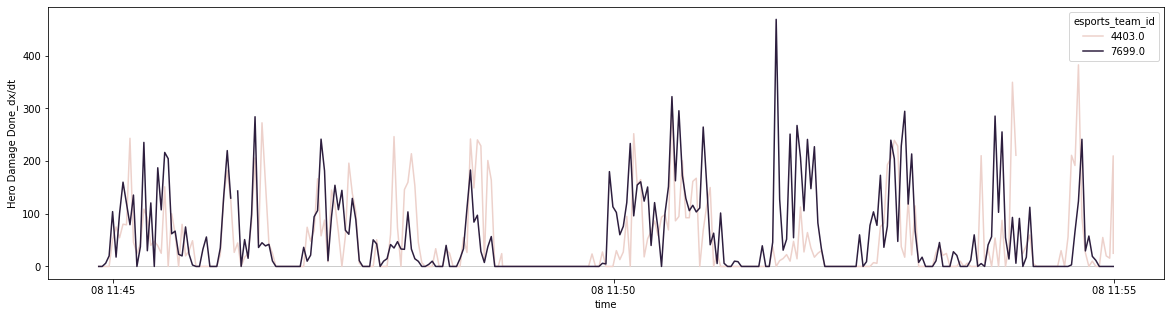

In [162]:
map1 = stat_report.xs(1, level='map_order').groupby(by=['time', 'esports_team_id']).sum()
plt.figure(figsize=(20,5))
sns.lineplot(x='time', y=0, data=map1, color='black', alpha=0, linewidth=1, linestyle=':')
sns.lineplot(x='time', y='Hero Damage Done_dx/dt', data=map1, hue='esports_team_id')
plt.show()

In [134]:
dashboard = Dashboard(match_id)

# team dashboard
# team_dashboard = dashboard.get_dashboard('team')

# player dashboard
# dashboard.set_mode('map')
player_dashboard = dashboard.get_dashboard('team')
display(player_dashboard)

SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '43' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '42' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '1207' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '1301' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '401' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME

,Time Played,Final Blows,Deaths,Hero Damage Done,Barrier Damage Done,Hero Damage Taken,Healing Done,Healing Received,Ultimate Earned,Ultimate Used,Assists,Solo Kills
esports_team_id,,,,,,,,,,,,
4403.0,3170.989,46.0,33.0,41062.37,34768.6,51340.96,65705.04,36621.30,24.0,24.0,57.0,6.0
7699.0,3103.816,50.0,29.0,51262.22,42256.6,49304.16,46007.58,34299.22,22.0,21.0,80.0,6.0


In [91]:
timeplayed = match.import_esd(short_stat_guid=33)
df = match.import_esd(short_stat_guid=42)

timeplayed = timeplayed.groupby(by=['map_order', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].max()
dashboard = df.groupby(by=['map_order', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].max()
dashboard.rename(columns={'amount':'HR'}, inplace=True)

df_merge = pd.merge(timeplayed, dashboard, how='outer', left_index=True, right_index=True).fillna(0)

display(df_merge)

# dashboard_team_match_agg = dashboard.groupby(by=['esports_team_id'])[['amount']].sum()
# dashboard_player_match_agg = dashboard.groupby(by=['esports_team_id', 'battletag', 'hero_name'])[['amount']].sum()
# display(dashboard_player_match_agg)
# display(dashboard)

SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '42' ORDER BY `time`;


amount   HR
map_order esports_team_id battletag hero_name                
1         4403.0          BiaNcA    Sigma      320.20400  3.0
                                    Zarya      245.31200  3.0
                          Haksal    Genji      562.59400  4.0
                                    Symmetra     2.92228  0.0
                          JJonak    Ana         81.77660  0.0
...                                                  ...  ...
5         7699.0          Rio       Reinhardt   62.31010  1.0
                                    Winston    569.35100  8.0
                          shu       Ana        316.30900  2.0
                                    Baptiste    64.25770  0.0
                                    Moira      251.09400  1.0

[140 rows x 2 columns]

In [7]:
# Teamfight trends
# teamfight dashboard
# HDD, FB, Death, Ult earned, Ult used, TPB, Resources earned after teamfight:{ultimates, objective scores(gameinfo)}
teamfight = Teamfight(match_id=34912)
df_trend = teamfight.get_TF_trends(short_stat_guid=44)

SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '33' ORDER BY `time`;
SELECT * FROM `match_34912` WHERE `stat_lifespan` = 'GAME' AND `stat_category` = 'Hero' AND `short_stat_guid` = '44' ORDER BY `time`;


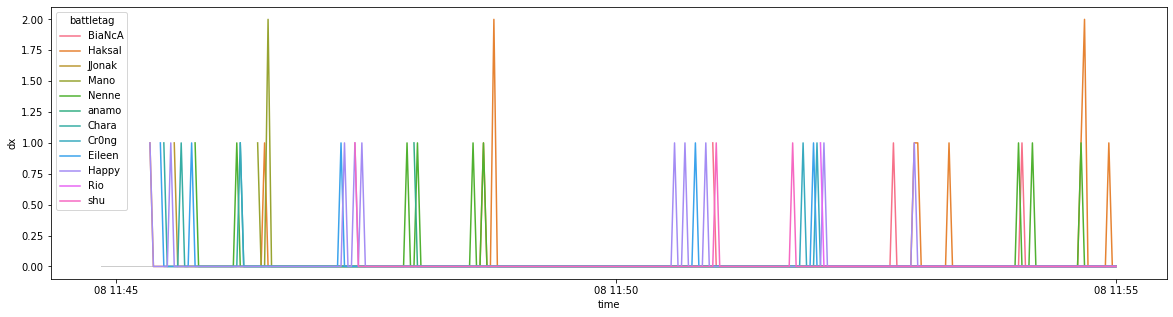

In [135]:
plt.figure(figsize=(20,5))
sns.lineplot(x='time', y=0, data=df_trend, color='black', alpha=0, linewidth=1, linestyle=':') # time-axis
sns.lineplot(x='time', y='dx', data=df_trend, hue='battletag')
plt.show()

,Unnamed: 0,TF_start_datetime,TF_end_datetime,esports_match_id,map_name,map_order,TF_order,TF_winner,TF_duration,TF_TPB_sum,TF_TPB_sum/s
0,0,2020-08-08 11:45:20+00:00,2020-08-08 11:45:54+00:00,34912,Busan,1,1,Guangzhou Charge,30,-698.0,-23.266667
1,1,2020-08-08 11:46:00+00:00,2020-08-08 11:46:38+00:00,34912,Busan,1,2,New York Excelsior,34,526.0,15.470588
2,2,2020-08-08 11:46:54+00:00,2020-08-08 11:47:34+00:00,34912,Busan,1,3,Guangzhou Charge,36,-1093.0,-30.361111
3,3,2020-08-08 11:47:42+00:00,2020-08-08 11:48:08+00:00,34912,Busan,1,4,New York Excelsior,22,582.0,26.454545
4,4,2020-08-08 11:48:28+00:00,2020-08-08 11:48:54+00:00,34912,Busan,1,5,New York Excelsior,22,1115.0,50.681818
5,5,2020-08-08 11:49:52+00:00,2020-08-08 11:51:08+00:00,34912,Busan,1,6,Guangzhou Charge,72,-1010.0,-14.027778
6,6,2020-08-08 11:51:30+00:00,2020-08-08 11:52:12+00:00,34912,Busan,1,7,Guangzhou Charge,38,-1105.0,-29.078947
7,7,2020-08-08 11:52:28+00:00,2020-08-08 11:53:08+00:00,34912,Busan,1,8,New York Excelsior,36,423.0,11.750000
8,8,2020-08-08 11:53:12+00:00,2020-08-08 11:53:26+00:00,34912,Busan,1,9,New York Excelsior,10,253.0,25.300000
9,9,2020-08-08 11:53:34+00:00,2020-08-08 11:54:16+00:00,34912,Busan,1,10,New York Excelsior,38,645.0,16.973684


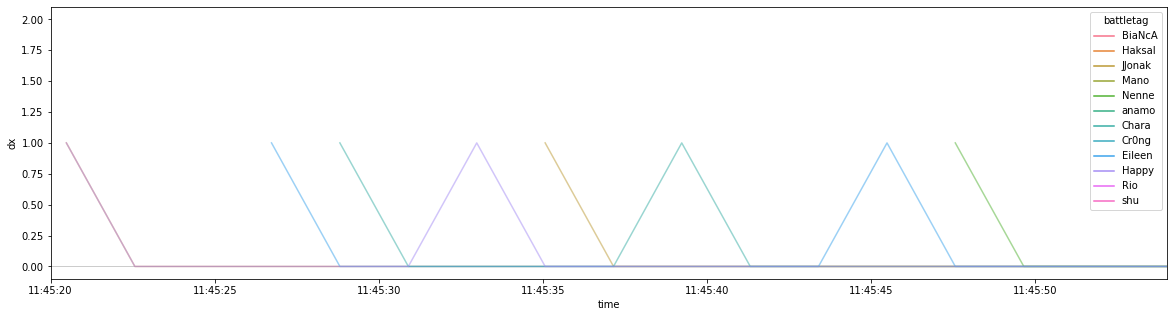

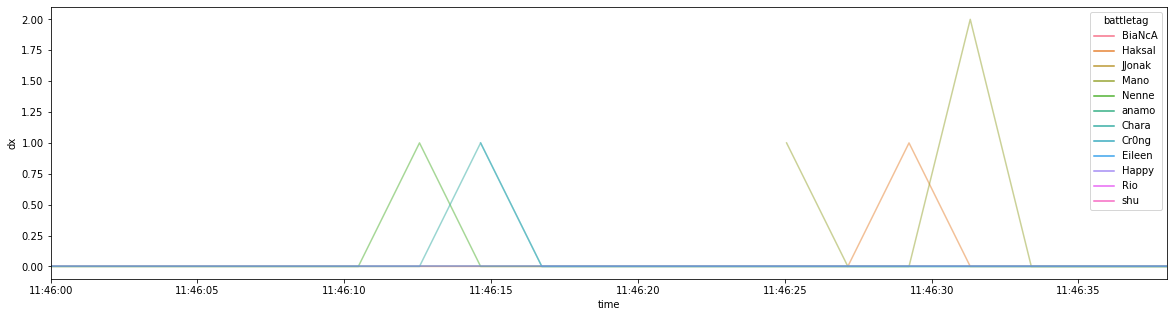

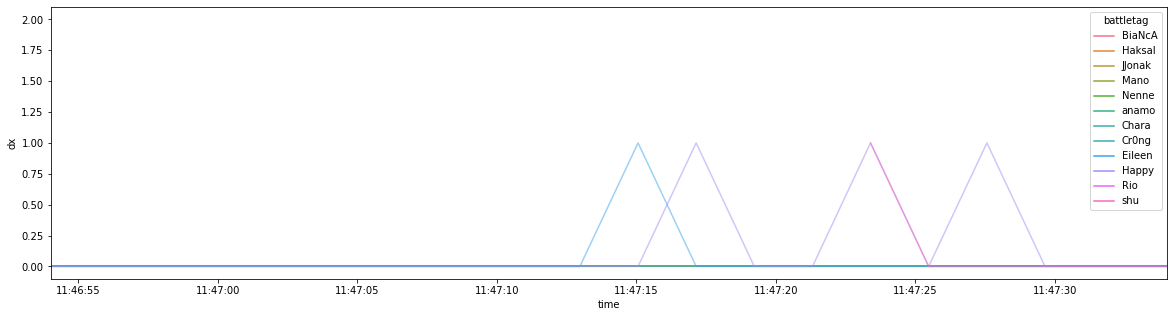

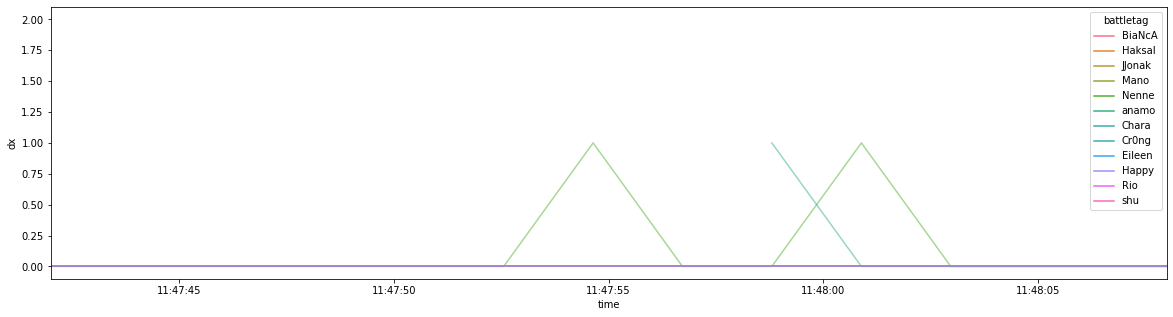

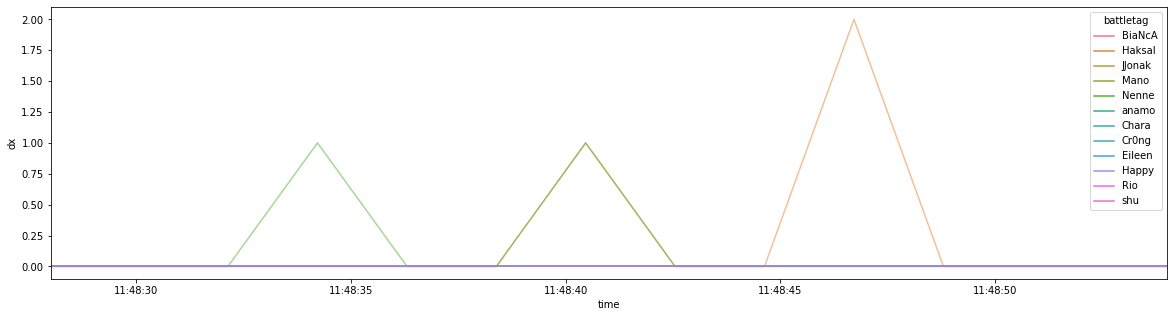

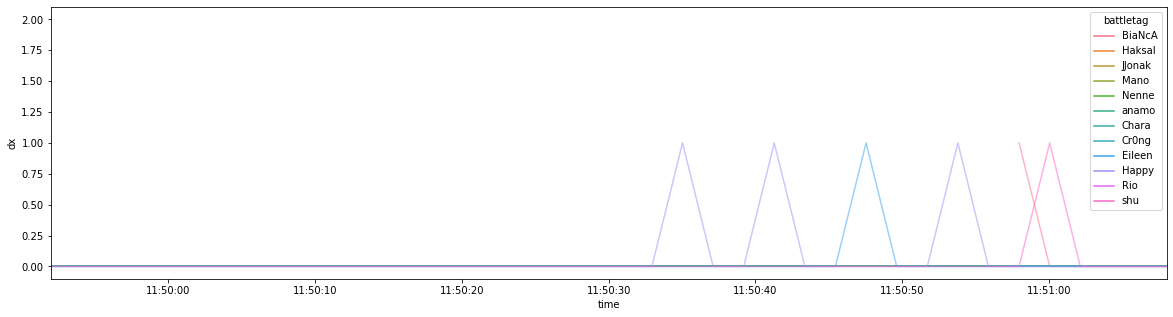

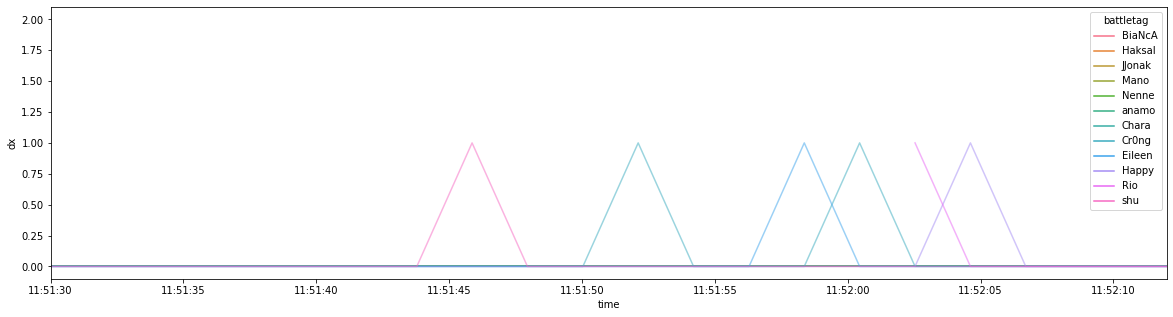

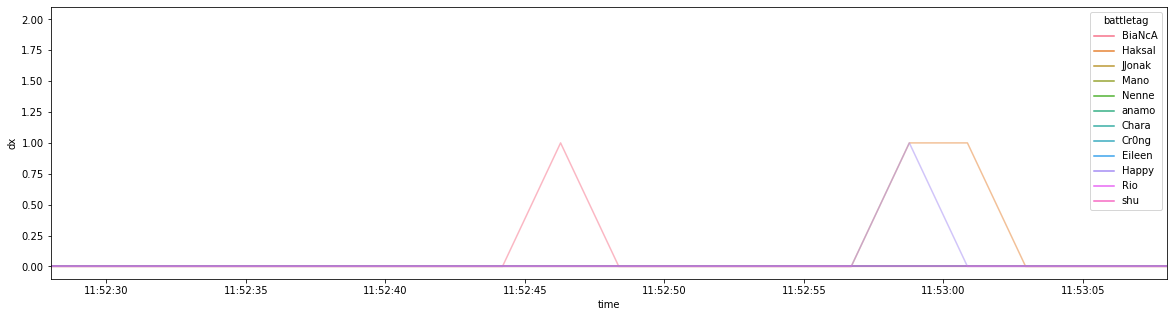

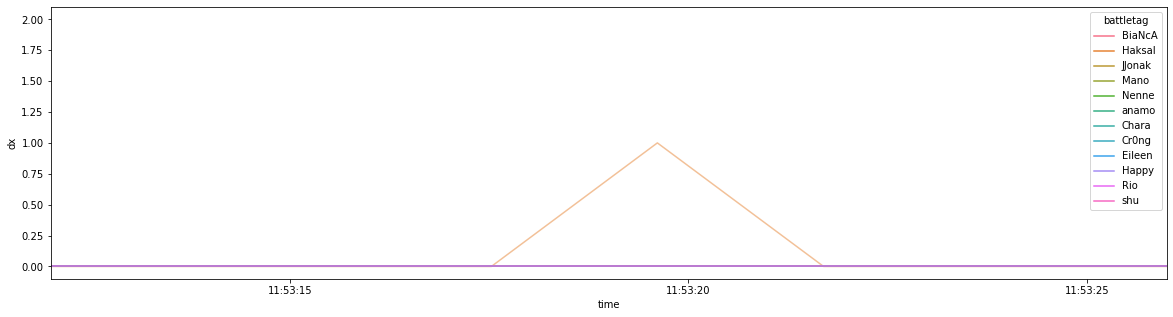

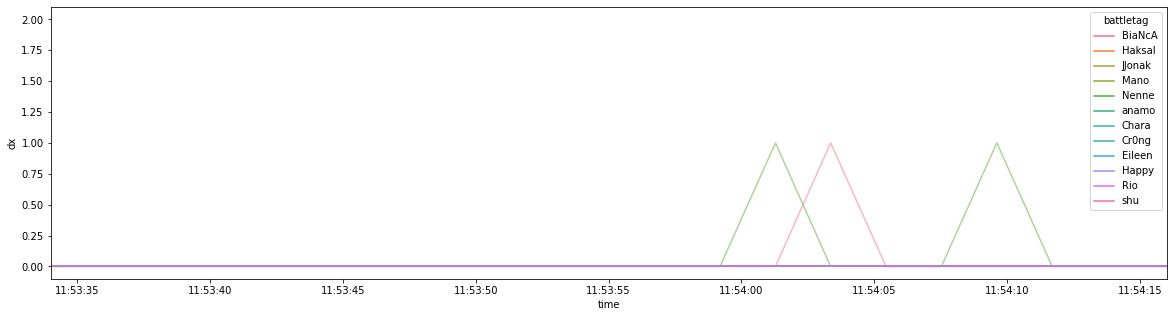

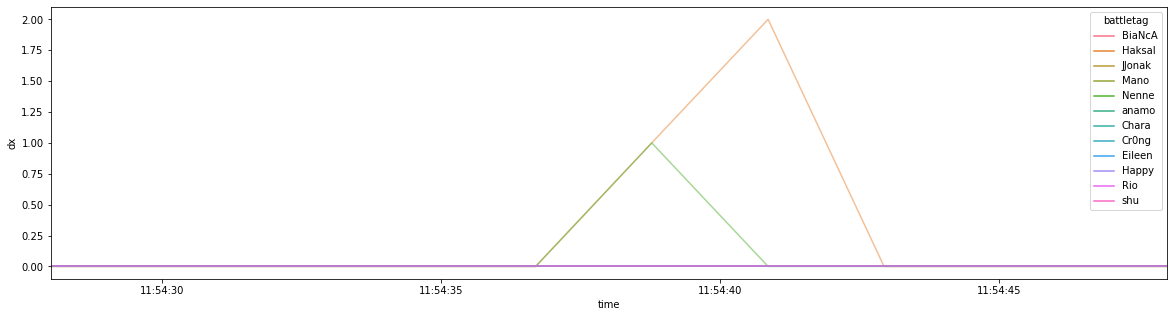

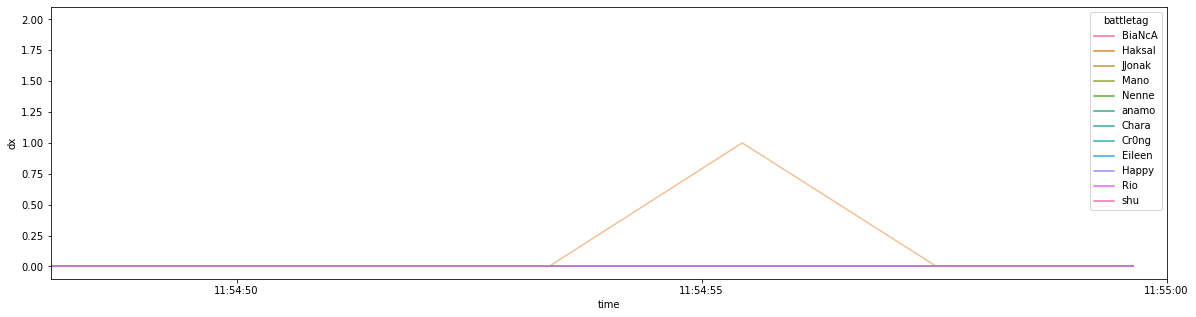

In [11]:
possible_time_variance = 2 # sec
# import TF info
tf_timeline = pd.read_csv(os.path.join('results/tf_info', f'{match_id}.csv'))
tf_timeline['TF_start_datetime'] = pd.to_datetime(tf_timeline['TF_start_datetime'], format='%Y-%m-%d %H:%M:%S') - pd.to_timedelta(possible_time_variance, unit='s')
tf_timeline['TF_end_datetime'] = pd.to_datetime(tf_timeline['TF_end_datetime'], format='%Y-%m-%d %H:%M:%S') + pd.to_timedelta(possible_time_variance, unit='s')

tf_timeline = tf_timeline[tf_timeline['map_order'] == 1]

display(tf_timeline)

for idx in tf_timeline.index:
    plt.figure(figsize=(20,5))
    sns.lineplot(x='time', y=0, data=df_trend, color='black', alpha=0, linewidth=1, linestyle=':') # time-axis
    sns.lineplot(x='time', y='dx', data=df_trend, hue='battletag', alpha=0.5)
    
    start, end = tf_timeline.loc[idx, 'TF_start_datetime'],tf_timeline.loc[idx, 'TF_end_datetime']

    plt.xlim(start, end)
    plt.show()

## Stats

In [ ]:
class TeamfightESD:
    def __init__(self, match_id):
        self.match_id = match_id
    
    def import_from_db(self, stat_lifespan='GAME', stat_category='Hero', **kwargs):
        '''
        parameters: match_id
                    kwargs: ['index', 'time', 'hero_guid', 'stat_lifespan', 'hero_name', 'short_stat_guid', 'amount', 'stat_name', 'stat_category', 'battletag', 'esports_player_id', 'esports_team_id']
        
        returns:    pd.DataFrame from MySQL DB
        '''
        # get sql from parameters
        table_id = f'match_{self.match_id}'
        sql = f"SELECT * FROM `{table_id}` WHERE `stat_lifespan` = '{stat_lifespan}' AND `stat_category` = '{stat_category}'"
        
        if len(kwargs) != 0:
            for name, value in kwargs.items():
                sql = sql + f" AND `{name}` = '{value}'"
        sql = sql + " ORDER BY `time`;"
        print(sql)

        # Credentials to DB connection
        hostname = "localhost" 
        username = "root"
        pwd = "gpdlzjadh"
        dbname = "esd_phs"
        charset = "utf8"

        # Create connection to MySQL DB
        conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
        cur = conn.cursor()

        # send query
        df = pd.read_sql(sql, conn)

        cur.close()
        conn.close()

        # preprocess dataframe
        # convert `time` column type from str to datetime
        df['time'] = df['time'].astype(float)
        df['time'] = df['time'] / 1000 # ms to s
        df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
        
        df['battletag'] = df['battletag'].str.split('#').str[0] # drop str after '#' in `battletag`
        df = df[df.columns.difference(['index'])] # drop `index` column
        df.set_index('time', inplace=True) # set 'time' column as index

        # import map start time info
        ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id=self.match_id)

        # slice only map played timeline
        self.esd_tf = pd.DataFrame()
        for idx in ts_map_start.index:
            start, end = to_datetime(ts_map_start.loc[idx]), to_datetime(ts_map_end.loc[idx])
            df_tmp = df[start:end]
            df_tmp['map_order'] = idx + 1
            
            self.esd_tf = pd.concat([self.esd_tf, df_tmp], ignore_index=False) # index:datetime

        
        return self.esd_tf

In [ ]:
# Teamfight Trends

def get_TF_trends(match_id=None, short_stat_guid=None, map_order=1):
    '''
    paramters:  match_id:  
                short_stat_guid:
                map_order:
    
    returns:    dataframe
    '''
    # get ESD from MySQL DB
    timeplayed = TeamfightESD(match_id).import_from_db(short_stat_guid=33) # get timeplayed to set time-axis
    timeplayed = timeplayed[timeplayed['map_order'] == map_order]
    target_stat = TeamfightESD(match_id).import_from_db(short_stat_guid=short_stat_guid)
    target_stat = target_stat[target_stat['map_order'] == map_order]

    # grouping
    group_timeplayed = timeplayed.groupby(by=['time', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].mean()
    group_target_stat = target_stat.groupby(by=['time', 'esports_team_id', 'battletag', 'hero_name'])[['amount']].mean()

    # get amount, dx, dt, dx/dt
    df_merge = pd.merge(group_timeplayed, group_target_stat, how='outer', left_index=True, right_index=True, suffixes=('_timeplayed', '_target_stat'))
    # df_merge['amount_target_stat'].fillna(0, inplace=True) # initialize stat value

    df_merge['dx'] = df_merge.groupby(level=['esports_team_id', 'battletag', 'hero_name'])['amount_target_stat'].diff().fillna(df_merge['amount_target_stat']) # fill nan as first value
    df_merge['dt'] = df_merge['dx'].reset_index('time').groupby(level=['esports_team_id', 'battletag', 'hero_name'])['time'].diff().dt.seconds.values
    df_merge['dx/dt'] = df_merge['dx'].div(df_merge['dt'], axis=0)

    # reset index of esports_team_id
    df_merge.reset_index('esports_team_id', inplace=True)
    
    return df_merge

In [ ]:
match_id = 34912
df = get_TF_trends(match_id=match_id, short_stat_guid=1208)

plt.figure(figsize=(20,5))
sns.lineplot(x='time', y=0, data=df, color='black', alpha=0, linewidth=1, linestyle=':') # time-axis
sns.lineplot(x='time', y='dx', data=df, hue='battletag')
plt.show()

In [ ]:
df_team = df.groupby(by=['time', 'esports_team_id']).sum()
plt.figure(figsize=(20,5))
sns.lineplot(x='time', y=0, data=df_team, color='black', alpha=0, linewidth=1, linestyle=':') # time-axis
sns.lineplot(x='time', y='dx', data=df_team, hue='esports_team_id')
plt.show()

In [ ]:
possible_time_variance = 2 # sec
# import TF info
tf_timeline = pd.read_csv(os.path.join('results/tf_info', f'{match_id}.csv'))
tf_timeline['TF_start_datetime'] = pd.to_datetime(tf_timeline['TF_start_datetime'], format='%Y-%m-%d %H:%M:%S') - pd.to_timedelta(possible_time_variance, unit='s')
tf_timeline['TF_end_datetime'] = pd.to_datetime(tf_timeline['TF_end_datetime'], format='%Y-%m-%d %H:%M:%S') + pd.to_timedelta(possible_time_variance, unit='s')

tf_timeline = tf_timeline[tf_timeline['map_order'] == 1]

display(tf_timeline)

for idx in tf_timeline.index:
    plt.figure(figsize=(20,5))
    sns.lineplot(x='time', y=0, data=df, color='black', alpha=0, linewidth=1, linestyle=':') # time-axis
    sns.lineplot(x='time', y='dx', data=df, hue='battletag', alpha=0.5)
    
    start, end = tf_timeline.loc[idx, 'TF_start_datetime'],tf_timeline.loc[idx, 'TF_end_datetime']

    plt.xlim(start, end)
    plt.show()

In [ ]:
# Teamfight Dashboard

def get_TF_dashboard():

## Old

In [ ]:
class TeamfightESD:
    def __init__(self, match_id):
        self.match_id = match_id
    
    def import_from_db(self, stat_lifespan='GAME', stat_category='Hero', **kwargs):
        '''
        parameters: match_id
                    kwargs: ['index', 'time', 'hero_guid', 'stat_lifespan', 'hero_name', 'short_stat_guid', 'amount', 'stat_name', 'stat_category', 'battletag', 'esports_player_id', 'esports_team_id']
        
        returns:    pd.DataFrame from MySQL DB
        '''
        # get sql from parameters
        table_id = f'match_{self.match_id}'
        sql = f"SELECT * FROM `{table_id}` WHERE `stat_lifespan` = '{stat_lifespan}' AND `stat_category` = '{stat_category}'"
        
        if len(kwargs) != 0:
            for name, value in kwargs.items():
                sql = sql + f" AND `{name}` = '{value}'"
        sql = sql + " ORDER BY `time`;"
        print(sql)

        # Credentials to DB connection
        hostname = "localhost" 
        username = "root"
        pwd = "gpdlzjadh"
        dbname = "esd_phs"
        charset = "utf8"

        # Create connection to MySQL DB
        conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
        cur = conn.cursor()

        # table names from mysql db
        db_name = 'esd_phs'

        # send query
        df = pd.read_sql(sql, conn)

        cur.close()
        conn.close()

        # preprocess dataframe
        # convert `time` column type from str to datetime
        df['time'] = df['time'].astype(float)
        df['time'] = df['time'] / 1000 # ms to s
        df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
        
        df['battletag'] = df['battletag'].str.split('#').str[0] # drop str after '#' in `battletag`
        df = df[df.columns.difference(['index'])] # drop `index` column
        df.set_index('time', inplace=True) # set 'time' column as index

        # import TF info
        tf_timeline = pd.read_csv(os.path.join('results/tf_info', f'{self.match_id}.csv'))
        tf_timeline['TF_start_datetime'] = pd.to_datetime(tf_timeline['TF_start_datetime'], format='%Y-%m-%d %H:%M:%S')
        tf_timeline['TF_end_datetime'] = pd.to_datetime(tf_timeline['TF_end_datetime'], format='%Y-%m-%d %H:%M:%S')

        # slice only TF timeline
        self.esd_tf = pd.DataFrame()
        for idx in tf_timeline.index:
            start, end = tf_timeline.loc[idx, 'TF_start_datetime'], tf_timeline.loc[idx, 'TF_end_datetime']
            df_tmp = df[start:end]
            df_tmp['map_name'] = tf_timeline.loc[idx, 'map_name']
            df_tmp['map_order'] = tf_timeline.loc[idx, 'map_order']
            df_tmp['TF_order'] = tf_timeline.loc[idx, 'TF_order']
            df_tmp['TF_winner'] = tf_timeline.loc[idx, 'TF_winner']
            df_tmp['TF_duration'] = tf_timeline.loc[idx, 'TF_duration']
            df_tmp['TF_TPB_sum'] = tf_timeline.loc[idx, 'TF_TPB_sum']
            df_tmp['TF_TPB_sum/s'] = tf_timeline.loc[idx, 'TF_TPB_sum/s']
            
            self.esd_tf = pd.concat([self.esd_tf, df_tmp], ignore_index=False) # index:datetime
        
        return self.esd_tf


In [ ]:
x = TeamfightESD(34912)
df = x.import_from_db(short_stat_guid=44)
display(df.head())

In [ ]:
# search match_id
match_ids = get_esports_match_ids(team_name='New York Excelsior', opponent_name='Shanghai Dragons', winner='Shanghai Dragons', season=2020)
print(match_ids)

In [ ]:
## SSG dict
tf_def_ssg_dict = {'Final |Rpl {0}:Blow:Blows;':44, 'All Damage Done':201, 'Time Played':38, 'Healing Done':465, 'Damage Blocked':675, '|Rpl {0}:Ultimate:Ultimates; Earned':1124, '|Rpl {0}:Ultimate:Ultimates; Used':1125, '|Rpl {0}:Shot:Shots; Fired':1132, 'Hero Damage Done':1208, '|Rpl {0}:Death:Deaths;':41}
tf_def_ssg_dict.values()

## Save esd_tf to MySQL DB

In [ ]:
# save esd_tf to mysql DB
def export_to_db(esd_tf, dbname="teamfight"):
    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    port = 3306
    # dbname = "teamfight" # schema name to export the df
    charset = "utf8"

    # Create engine
    engine = create_engine('mysql+pymysql://' + username + ':' + pwd + '@' + hostname + ':' + str(port) + '/' + dbname , echo=False)

    # export dataframe into mysql
    table_id = f'match_{match_id}'
    esd_tf.to_sql(name=table_id, con=engine, schema=dbname, if_exists='fail')


In [ ]:
match_id = 34912
esd_tf = TeamfightESD(match_id).import_from_db()
# export_to_db(esd_tf) # save esd_tf to MySQL DB

## Visualization

In [ ]:
def TF_sortby_battletag(data=None, short_stat_guid=1208, map_order=1, TF_order=1, plotting=False, plot_output='dx/dt'):
    '''
    parameters: data: pd.DataFrame (esd_tf)
                hero_name: str
                short_stat_guid: int
                map_order: int
                TF_order: int
                plotting: bool
                plot_output: {'amount', 'dx', 'dx/dt', 'event'} 

    returns:    pd.DataFrame
    '''
    esd_tf = data

    # import TF timeline
    tf_timeline = pd.read_csv(os.path.join('results/tf_info', f'{match_id}.csv'))
    tf_timeline = tf_timeline[(tf_timeline['map_order'] == map_order) & (tf_timeline['TF_order'] == TF_order)]
    tf_timeline['TF_start_datetime'] = pd.to_datetime(tf_timeline['TF_start_datetime'], format='%Y-%m-%d %H:%M:%S')
    tf_timeline['TF_end_datetime'] = pd.to_datetime(tf_timeline['TF_end_datetime'], format='%Y-%m-%d %H:%M:%S')

    for idx in tf_timeline.index:
        start, end = tf_timeline.loc[idx, 'TF_start_datetime'], tf_timeline.loc[idx, 'TF_end_datetime']

        timeline = pd.date_range(start, end, freq='S')
        timeline.name = 'time'

        print(f'TF start:{start}, TF end:{end}')

    # timeplayed > to unify timeline of each short_stat_guid
    timeplayed = esd_tf[(esd_tf['short_stat_guid'] == 38) & (esd_tf['map_order'] == map_order) & (esd_tf['TF_order'] == TF_order)] # timeplayed: hero_name = 'no match'
    timeplayed = timeplayed[['battletag']]

    # slicing
    tf0 = esd_tf[(esd_tf['short_stat_guid'] == short_stat_guid) & (esd_tf['map_order'] == map_order) & (esd_tf['TF_order'] == TF_order)]
    tf0 = pd.merge(timeplayed, tf0, on='time', how='outer', suffixes=('_timeplayed', ''))
    display(tf0)
    print(f'# nan values in tf0: {tf0.isna().sum()}')
    
    # title
    map_name = tf0['map_name'][0]
    stat_name = tf0['stat_name'][0]
    TF_winner = tf0['TF_winner'][0]
    TF_duration = tf0['TF_duration'][0]
    TF_TPB_sum_per_sec = tf0['TF_TPB_sum/s'][0]

    # get dx, dx/dt
    tf1 = tf0.groupby(['time', 'battletag', 'hero_name']).mean()

    dx = tf1.groupby(['battletag', 'hero_name'])['amount'].diff().fillna(0) # set the first dx value as the first amount value to avoid dx starting at 0
    dx.name = 'dx'
    tf2 = tf1.reset_index('time')
    dt = tf2.groupby(['battletag', 'hero_name'])['time'].diff().dt.seconds.values
    dxdt = dx.div(dt, axis=0) 
    dxdt.name = 'dx/dt'

    tf1 = tf1.merge(dx, how='left', left_index=True, right_index=True)
    tf1 = tf1.merge(dxdt, how='left', left_index=True, right_index=True)

    display(tf1)

    # plotting
    if plotting == True:
        plt.figure(figsize=(20,10))
        plt.title(f'map_#{map_order}:{map_name}_TF#{TF_order}_winner_{TF_winner}_duration:{TF_duration}s_TPB/s:{round(TF_TPB_sum_per_sec, 2)}')
        sns.lineplot(x='time', y=plot_output, data=tf1, hue='battletag')
        plt.show()

    return tf1

In [ ]:
# ESD 별로 amount, dx/dt, dx, event data 4가지로 나눠서 categorize
# teamfight report에 필요한 stat selection
# hero_name search 없애고 ssg, map_order, TF_order로 먼저 search 후 hero_name을 print 하는 방법? {battletag:hero_name}

In [ ]:
test = esd_tf[(esd_tf['short_stat_guid']==1207)]
test2 = test.groupby('battletag').sum()
display(test2)

In [ ]:
(esd_tf[esd_tf['hero_name'] == 'Genji']['stat_name'].unique())

In [ ]:
# plot
TF_num = (esd_tf[esd_tf['map_order'] == 1]['TF_order']).unique()
for t in (TF_num):
    try:
        df_bt = TF_sortby_battletag(data=esd_tf, short_stat_guid=1208, plotting=True, plot_output='dx/dt', map_order=1, TF_order=t)
    except:
        print(f'no data in teamfight #{t}. check hero_name and ssg')

In [ ]:
# dx 값을 구할 때 ESD가 애초에 데이터가 0인 값은 체크를 하지 않기 때문에 첫 event가 발생하면 1부터 시작함. 그래서 event가 떠도 dx는 0으로 잡히니까 헷갈림. amount 시작 값이 찍힌 부분만 dx를 amount 값으로 맞춰주면 괜찮을 듯. 이후 한타들은 그대로 가도 될 듯.